In [1]:
!pip -q install datasets==2.20.0 scikit-learn==1.4.2 xgboost==2.0.3 lightgbm==4.3.0 matplotlib==3.8.4 joblib==1.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 17.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.4.2 which is incompatible.
cuml-cu12 25.6.0 requires scikit-learn>=1.5, but you have scikit-learn 1.4.2 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 

In [2]:
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random,os

SEED = 42
random.seed(SEED);np.random.seed(SEED)

In [3]:
df = load_dataset("Hello-SimpleAI/HC3", "all" , trust_remote_code=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/24322 [00:00<?, ? examples/s]

In [4]:
split_names = list(df.keys())
print(split_names)

data_split = "train" if "train" in split_names else split_names[0]
print(data_split)

raw = df[data_split]

['train']
train


In [5]:
rows = []
for ex in raw:
    q = ex.get("question", "")
    cat = ex.get("category", ex.get("source", "unknown"))

    # Human answers
    for h in ex.get("human_answers", []) or []:
        if isinstance(h, str) and h.strip():
            rows.append({"text": h.strip(), "label": 0, "category": cat, "question": q})

    # AI answers
    for a in ex.get("chatgpt_answers", []) or []:
        if isinstance(a, str) and a.strip():
            rows.append({"text": a.strip(), "label": 1, "category": cat, "question": q})

df = pd.DataFrame(rows).dropna(subset=["text"])
df = df[df["text"].str.len() > 10].reset_index(drop=True)

print("Total num. of Samples:", len(df))
print(df["label"].value_counts(), "\n")


Total num. of Samples: 85429
label
0    58544
1    26885
Name: count, dtype: int64 



In [6]:
x = df["text"].values
y = df["label"].values

from sklearn.model_selection import train_test_split
x_train,x_tmp,y_train,y_tmp = train_test_split(x,y,test_size=0.3,random_state=SEED,stratify = y)
x_val,x_test,y_val,y_test = train_test_split(x_tmp,y_tmp,test_size=0.5,random_state=SEED,stratify = y_tmp)

print("train",x_train.shape,"Val: ",x_val.shape,"Test: ",x_test.shape)

train (59800,) Val:  (12814,) Test:  (12815,)


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2),max_features = 200000, min_df = 2)
x_train_tfidf = vectorizer.fit_transform(x_train)
x_val_tfidf = vectorizer.transform(x_val)
x_test_tfidf = vectorizer.transform(x_test)

In [8]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = {cls: w for cls, w in zip(classes, cw)}
class_weight_dict


{np.int64(0): np.float64(0.7296064029672287),
 np.int64(1): np.float64(1.5888198097667252)}

In [9]:
import numpy as np

print("Full dataset:", np.unique(y, return_counts=True))
print("Train:", np.unique(y_train, return_counts=True))
print("Val:", np.unique(y_val, return_counts=True))
print("Test:", np.unique(y_test, return_counts=True))


Full dataset: (array([0, 1]), array([58544, 26885]))
Train: (array([0, 1]), array([40981, 18819]))
Val: (array([0, 1]), array([8781, 4033]))
Test: (array([0, 1]), array([8782, 4033]))


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = {cls: w for cls, w in zip(classes, cw)}

lr = LogisticRegression(max_iter=2000, class_weight=class_weight_dict, n_jobs=-1)
lr.fit(x_train_tfidf, y_train)


LogisticRegression(class_weight={np.int64(0): np.float64(0.7296064029672287),
                                 np.int64(1): np.float64(1.5888198097667252)},
                   max_iter=2000, n_jobs=-1)

In [12]:
import lightgbm as lgb

lgb_clf = lgb.LGBMClassifier(
    n_estimators=300,max_depth = -1,learning_rate=0.1,subsample = 0.8,colsample_bytree = 0.8,random_state = SEED,
    objective = "binary",class_weight = "balanced"
)

lgb_clf.fit(
    x_train_tfidf,y_train,eval_set = [(x_val_tfidf,y_val)],eval_metric = 'logloss',
    callbacks = [lgb.early_stopping(30),lgb.log_evaluation(50)]
)

[LightGBM] [Info] Number of positive: 18819, number of negative: 40981
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 61.760922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1765053
[LightGBM] [Info] Number of data points in the train set: 59800, number of used features: 52908
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 30 rounds
[50]	valid_0's binary_logloss: 0.152567
[100]	valid_0's binary_logloss: 0.0872211
[150]	valid_0's binary_logloss: 0.063743
[200]	valid_0's binary_logloss: 0.0519063
[250]	valid_0's binary_logloss: 0.0449668
[300]	valid_0's binary_logloss: 0.0405415
Did not meet early stopping. Best iteration is:
[300]	valid_0's binary_logloss: 0.0405415


LGBMClassifier(class_weight='balanced', colsample_bytree=0.8, n_estimators=300,
               objective='binary', random_state=42, subsample=0.8)

In [14]:
from sklearn.metrics import roc_auc_score ,confusion_matrix,classification_report


y_val_pred = lgb_clf.predict(x_val_tfidf)
y_val_proba = lgb_clf.predict_proba(x_val_tfidf)[:,1]

print("Classification Report :\n",classification_report(y_val,y_val_pred))
print("ROC-AUC",roc_auc_score(y_val,y_val_proba))


Classification Report :
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      8781
           1       0.98      0.98      0.98      4033

    accuracy                           0.99     12814
   macro avg       0.98      0.98      0.98     12814
weighted avg       0.99      0.99      0.99     12814

ROC-AUC 0.998963115282859


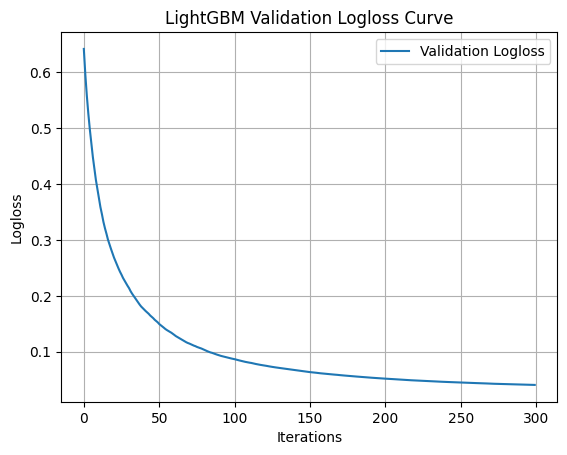

In [17]:
results = lgb_clf.evals_result_
plt.plot(results['valid_0']['binary_logloss'] , label = 'Validation Logloss')
plt.xlabel("Iterations")
plt.ylabel("Logloss")
plt.title("LightGBM Validation Logloss Curve")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
import joblib

joblib.dump(lgb_clf, "lightgbm_ai_detector.pkl")

joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("Artifacts saved: lightgbm_ai_detector.pkl , tfidf_vectorizer.pkl")


Artifacts saved: lightgbm_ai_detector.pkl , tfidf_vectorizer.pkl


In [19]:
lgb_model = joblib.load("lightgbm_ai_detector.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

print("Artifacts loaded successfully")


Artifacts loaded successfully


In [20]:
def detect_ai_text(texts, model, vectorizer, threshold=0.5):
    """
    Predict whether given text(s) are AI-written or Human-written.
    texts: string or list of strings
    threshold: probability cutoff (default = 0.5)
    """
    if isinstance(texts, str):
        texts = [texts]


    X = vectorizer.transform(texts)


    probs = model.predict_proba(X)[:,1]

    results = []
    for t, p in zip(texts, probs):
        label = "AI-generated" if p >= threshold else "Human-written"
        results.append({
            "text_preview": t[:100] + ("..." if len(t) > 100 else ""),
            "probability_AI": round(float(p), 4),
            "prediction": label
        })
    return results


In [21]:
corpus = [
    "The mitochondria is the powerhouse of the cell.",  #human-Written
    "In conclusion, leveraging cutting-edge advancements in natural language processing enables scalable synergies."  #AI-written
]

results = detect_ai_text(corpus, lgb_model, vectorizer)

for r in results:
    print(r)


{'text_preview': 'The mitochondria is the powerhouse of the cell.', 'probability_AI': 0.0057, 'prediction': 'Human-written'}
{'text_preview': 'In conclusion, leveraging cutting-edge advancements in natural language processing enables scalable ...', 'probability_AI': 0.0083, 'prediction': 'Human-written'}
